In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import muon_data, pileup_data, muon_data_split, pileup_data_split, \
                    mix_training_inputs

from nn_models import create_model, create_model_bn, create_model_sequential, \
                      lr_decay, modelbestcheck, modelbestcheck_weights

from nn_training import train_model, train_model_sequential

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.19.2


In [2]:
# Import muon data
# 'x' is the input variables with shape (n, 87), 'y' is the q/pT with shape (n, 1)
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.3)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

[INFO    ] Loading muon data from ../test7/histos_tba.16.npz ...
[INFO    ] Loaded the variables with shape (3312660, 87)
[INFO    ] Loaded the parameters with shape (3312660, 3)
[INFO    ] Loaded # of training and testing events: (2318862, 993798)


In [3]:
# Import pileup data
# 'x' is the input variables with shape (n, 87), 'aux' is pileup info with shape (n, 4)
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_job=30)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.zeros((pu_x_train.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.zeros((pu_x_test.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

[INFO    ] Loading pileup data from ../test7/histos_tbd.16.npz ...
[INFO    ] Loaded the variables with shape (351553, 87)
[INFO    ] Loaded the auxiliary PU info with shape (351553, 4)
[INFO    ] Loaded # of training and testing events: (169628, 181925)


In [4]:
# Create models
# model_seq is a densely connected NN with 3 hidden layers and 1 output node
# model is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

model_seq = create_model_sequential(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg)

#model_seq = create_model_sequential_regularized(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg)

model = create_model(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, discr_loss_weight=discr_loss_weight)
#model = create_model(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, nodes1=48, nodes2=24, nodes3=0,
#                     discr_loss_weight=discr_loss_weight)

#model = create_model_bn(nvariables=nvariables, lr=learning_rate, l1_reg=l1_reg, nodes1=48, nodes2=24, nodes3=0,
#                        discr_loss_weight=discr_loss_weight)

### Training

In [5]:
training_seq = False
training_func = True

In [6]:
# Training (Sequential)

if training_seq:
  assert(keras.backend.backend() == 'tensorflow')

  history = train_model_sequential(model_seq, x_train, y_train[0] if isinstance(y_train, list) else y_train, 
                                   model_name='model', epochs=200, batch_size=256,
                                   callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [7]:
# Training (Functional)

if training_func:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    x_train_new, y_train_new = mix_training_inputs(x_train, y_train, pu_x_train, pu_y_train, pu_aux_train, discr_pt_cut=discr_pt_cut)
  else:
    raise Exception('add_noise must be set to True')

  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=100, batch_size=8192,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

[INFO    ] Mixed muon data with pileup data. x_train_new has shape (4637724, 80), y_train_new has shape (4637724,),(4637724,)
[INFO    ] Begin training ...
[INFO    ] Saved model as model.h5, model.json and model_weights.h5
[INFO    ] Done training. Time elapsed: 0:18:17.187870 sec
[INFO    ] Epoch 100/100 - loss: 2.43743293653 - val_loss 2.45676172362


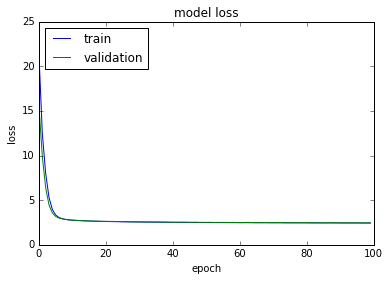

In [8]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=2048)

if training_seq or training_func:
  # Loss
  plt.figure()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.figure()
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.figure()
  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [9]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')
eps = 1e-4
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

# Setup Gaussian fit
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
  return 0.5*a*np.exp(-np.square((x-x0)/sigma))

def fit_gaus(hist, edges, mu=0., sig=1.):
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  return popt

In [10]:
# Load model and predict outputs
from nn_models import load_my_model
loaded_model = load_my_model(name='model', weights_name='model_weights')

nentries_test = x_test.shape[0]//4

# Prepare x_test_ndof
x_test_ndof = (x_mask_test[:nentries_test] == False).sum(axis=1)
#print x_test_ndof.shape, x_test_ndof

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale
#print y_test_true.shape, y_test_true
#print y_test_meas.shape, y_test_meas

[INFO    ] Loaded model from model.json and weights from model_weights.h5


[INFO    ] # of entries: 248449, mean: -0.000365582411177, std: 0.0327501744032
[INFO    ] gaus fit (a, mu, sig): [ 5.27175214e+04 -9.59221940e-04  2.84003478e-02]


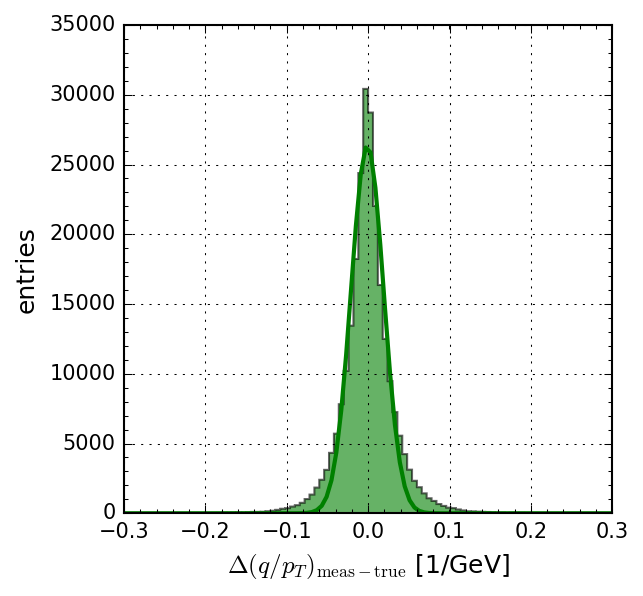

In [11]:
# Plot Delta(q/pT)
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

[INFO    ] # of entries: 248449, mean: 0.108159437776, std: 0.204998925328
[INFO    ] gaus fit (a, mu, sig): [ 6.28072594e+04 -8.24969298e-03  1.61889036e-01]


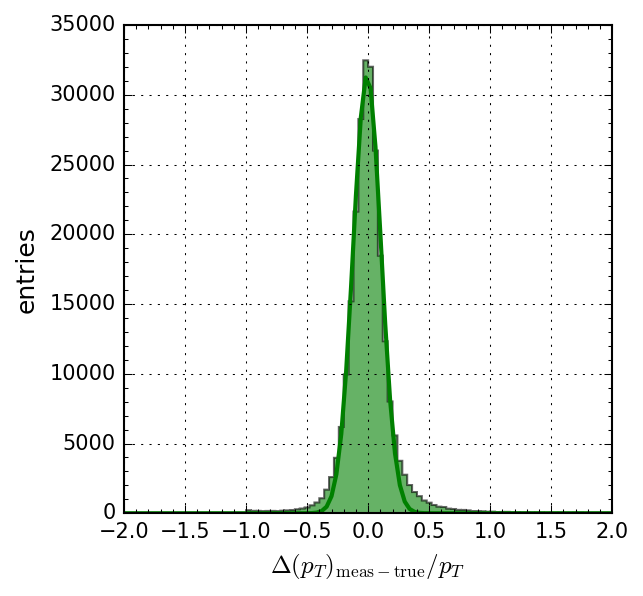

In [12]:
# Plot Delta(q/pT) / pT
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


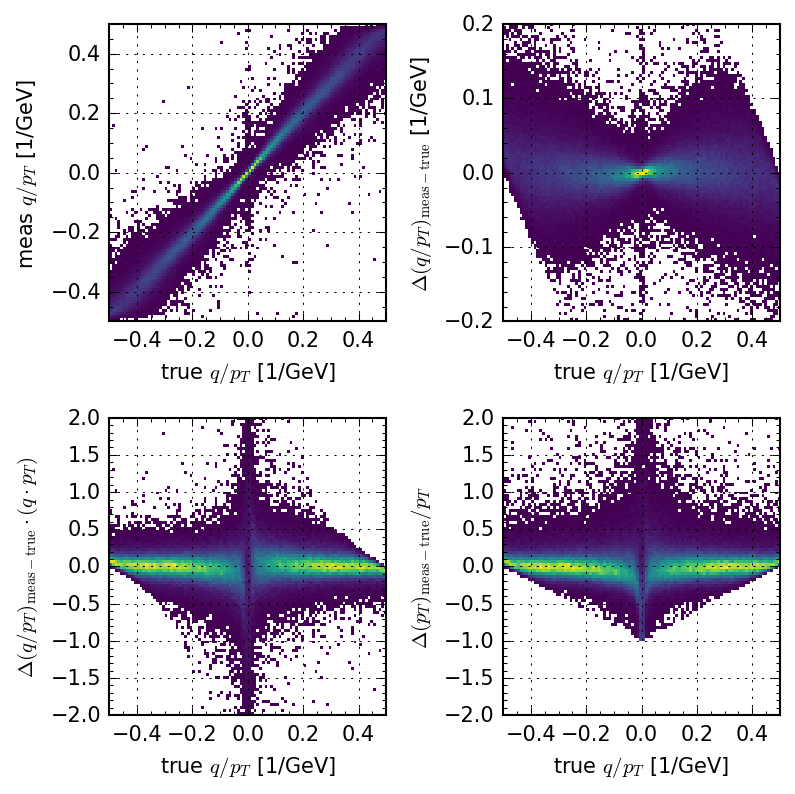

In [13]:
# Plot resolution plots
fig, axs = plt.subplots(2, 2, figsize=(5.4,5.4), tight_layout=True)

axs[0,0].hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
axs[0,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,0].set_ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)

yy = y_test_meas - y_test_true
axs[0,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
axs[0,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[0,1].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]', fontsize=10)

yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
axs[1,0].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,0].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,0].set_ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$', fontsize=10)

yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
axs[1,1].hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
axs[1,1].set_xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
axs[1,1].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

plt.show()

In [14]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[np.abs(yy_i) < 2]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

[INFO    ] gaus fit (a, mu, sig): [ 4.65231039e+02 -5.27421806e-02  2.56909668e-01]


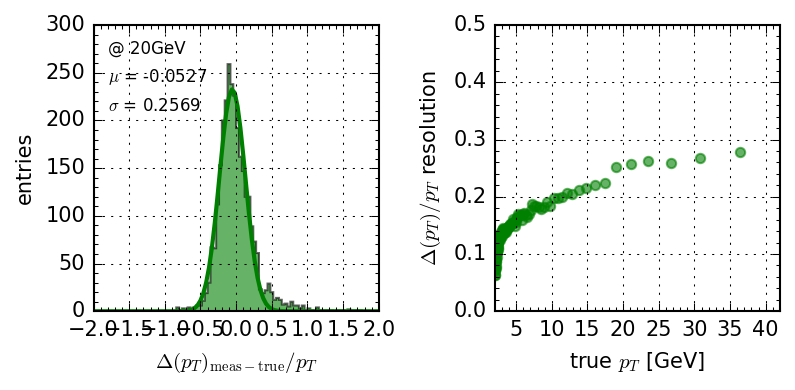

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(5.4,5.4/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=np.mean(yy_20GeV), sig=np.std(yy_20GeV[np.abs(yy_20GeV)<1.5]))
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx, yyy, color='g', alpha=0.6)
axs[1].set_xlim(2,42)
axs[1].set_ylim(0,0.5)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)

plt.show()

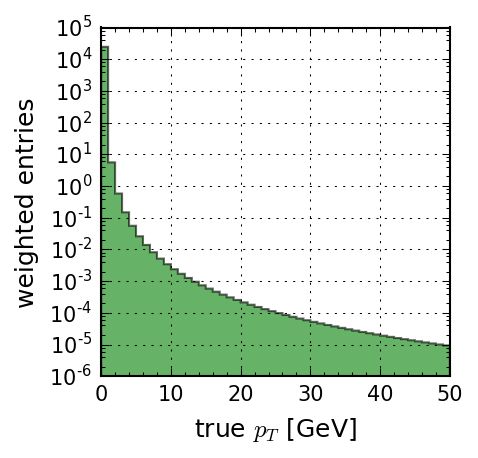

In [16]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [17]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 15.4842309952 rate 125.074287415
[INFO    ] 22 GeV threshold 16.8864479065 rate 98.5350646973


In [18]:
# Use the predicted rate as loss function/scoring in training
if True:
  from nn_models import NewKerasRegressor
  estimator = NewKerasRegressor(build_fn=create_model_sequential, reg_pt_scale=reg_pt_scale, min_pt=20., max_pt=22., coverage=90.,
                                nvariables=nvariables, lr=learning_rate)

  estimator.model = loaded_model

  # Cross check
  print estimator.score(x_test[:nentries_test], y_test[0][:nentries_test] if isinstance(y_test, list) else y_test)

-125.07429


### Classification Results

In [19]:
# Prepare pu_x_test_ndof
pu_x_test_ndof = (pu_x_mask_test == False).sum(axis=1)
#print pu_x_test_ndof.shape, pu_x_test_ndof

# Prepare y_test_true, y_test_meas
y_test_true = [y_test[0][:nentries_test, np.newaxis].copy(), y_test[1][:nentries_test, np.newaxis].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true = [y_test_true[0], y_test_true[1]]
y_test_meas = [y_test_meas[0], y_test_meas[1]]
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=2048)
pu_y_test_meas = [pu_y_test_meas[0].reshape(-1), pu_y_test_meas[1].reshape(-1)]
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

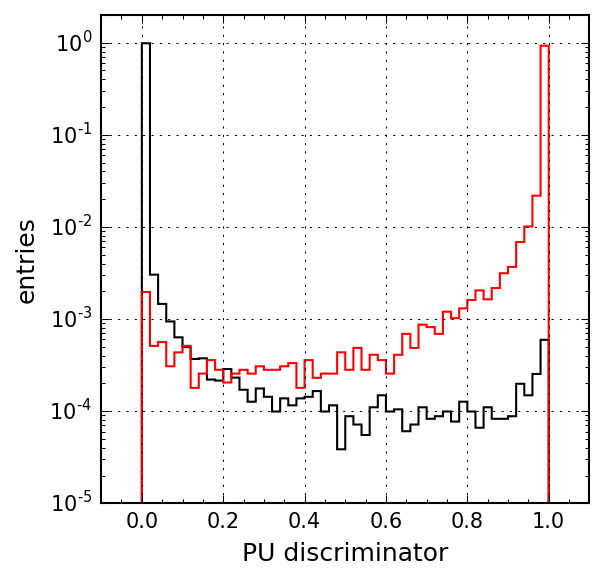

In [20]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black')
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red')
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

[INFO    ] auc: 0.998723320201
[INFO    ] thr: [0.9955, 0.9928, 0.9875, 0.9753, 0.9622, 0.9458, 0.9212, 0.8210, 0.3365]
[INFO    ] tpr: [0.9005, 0.9264, 0.9509, 0.9720, 0.9805, 0.9857, 0.9900, 0.9951, 0.9990]
[INFO    ] fpr: [0.0032, 0.0045, 0.0062, 0.0077, 0.0090, 0.0098, 0.0114, 0.0138, 0.0263]


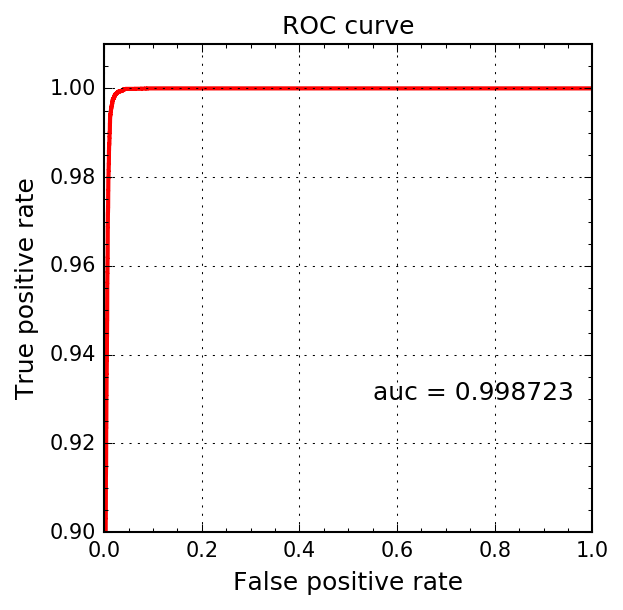

In [21]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))

zz_tmp = np.abs(1.0/zz) > discr_pt_cut
xx = xx[zz_tmp]
yy = yy[zz_tmp]

fpr, tpr, thresh = roc_curve(xx, yy)  # (y_true, y_meas)
auc = roc_auc_score(xx, yy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995, 0.999])
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.55, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,1.0)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [60]:
# Build a trigger object

pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - abs(ipt - best_ipt)

class MyTrigger(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8119,  1.5341,  1.5840,  1.8355,  2.2079,  2.6573,  3.1669,  3.7199,
                  4.3017,  4.9048,  5.5273,  6.1663,  6.8168,  7.4742,  8.1347,  8.8046,
                  9.4860, 10.1795, 10.8819, 11.5959, 12.3331, 13.0830, 13.8191, 14.5403,
                 15.2607, 16.0057, 16.7717, 17.5494, 18.3334, 19.1061, 19.8733, 20.6527,
                 21.4504, 22.2787, 23.0876, 23.8056, 24.4518, 25.1024, 25.8266, 26.6499,
                 27.4875, 28.3035, 29.1329, 30.0344, 30.9851, 31.8599, 32.6693, 33.5131,
                 34.4069, 35.2728, 36.0266, 36.7357, 37.5070, 38.4116, 39.3509, 40.2445,
                 41.1330, 42.0454, 43.0473, 44.1787, 45.3398, 46.4555, 47.6894, 49.1895,
                 50.4369, 51.3839, 52.2270, 53.0509, 53.8703, 54.6880, 55.5049, 56.3214,
                 57.1376, 57.9536, 58.7695, 59.5853, 60.4011, 61.2168, 62.0325, 62.8481,
                 63.6638, 64.4794, 65.2951, 66.1107, 66.9263, 67.7419, 68.5575, 69.3731,
                 70.1887, 71.0042, 71.8198, 72.6354, 73.4510, 74.2666, 75.0821, 75.8977,
                 76.7133, 77.5288, 78.3444, 79.1600, 79.9756, 80.7911, 81.6067, 82.4223,
                 83.2378, 84.0534, 84.8690, 85.6845, 86.5001, 87.3157, 88.1312, 88.9468,
                 89.7624, 90.5779, 91.3935, 92.2091, 93.0246, 93.8402, 94.6558, 95.4714]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]

  def get_trigger_pt(self, x, y_meas):
    #zone = int(x[(nlayers*6) + 1] * 5)

    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-8)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return int(binx)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if (binx+1) >= self.s_nbins:  # check boundary
      binx = self.s_nbins-2

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, x, ndof, y_meas, y_discr, discr_pt_cut=14.):
    trk_mode = 0
    x_mode_vars = np.equal(x[nlayers*6+3:nlayers*6+8], 1)
    for i, x_mode_var in enumerate(x_mode_vars):
      if i == 0:
        station = 1
      else:
        station = i
      if x_mode_var:
        trk_mode |= (1 << (4 - station))

    straightness = int(x[(nlayers*6) + 0] * 6) + 6

    ipt1 = straightness
    ipt2 = find_pt_bin(y_meas)
    quality1 = emtf_road_quality(ipt1)
    quality2 = emtf_road_quality(ipt2)

    if trk_mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > discr_pt_cut:
        if ndof <= 3:
          #trigger = (y_discr > 0.8)
          trigger = (y_discr > 0.9928)  # 95% coverage
          #trigger = (y_discr > 0.9999)  # 95% coverage
        else:
          #trigger = (y_discr > 0.5393)
          trigger = (y_discr > 0.9458) # 98.5% coverage
          #trigger = (y_discr > 0.9929) # 99% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

mytrigger = MyTrigger()

In [61]:
# Efficiency
eff_data = []

for x, ndof, y_meas, y_discr, y_true in zip(x_test, x_test_ndof, y_test_meas[0], y_test_meas[1], y_test_true[0]):
  zone = int(x[(nlayers*6) + 1] * 5)
  
  passed = mytrigger.pass_trigger(x, ndof, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed))

eff_data = np.asarray(eff_data)
print eff_data.shape, eff_data

(248449, 5) [[3.         4.06132793 4.95519733 5.47152042 1.        ]
 [3.         2.57501101 2.48083234 2.64007211 1.        ]
 [1.         2.55024886 2.47879624 2.63824224 1.        ]
 ...
 [3.         6.10882711 5.56175661 6.24664497 1.        ]
 [2.         4.21373606 4.38111353 4.76139927 1.        ]
 [0.         6.54953098 6.21289158 7.09671021 1.        ]]


10.0 [           nan            nan            nan 1.97211730e-04
 6.49525175e-04 3.12852414e-03 1.20633188e-02 1.07263149e-01
 5.79056915e-01 9.08589608e-01 9.61508614e-01 9.62233503e-01
 9.68561698e-01 9.74620962e-01 9.70645037e-01 9.72222222e-01
 9.75542406e-01 9.80000000e-01 9.77406236e-01 9.77375566e-01
 9.76631393e-01 9.74944072e-01 9.73420479e-01 9.72003500e-01]
20.0 [           nan            nan            nan 4.55103991e-05
 6.71922595e-05 2.91025501e-04 1.25545852e-03 3.15225840e-03
 1.15553004e-02 4.35843054e-02 1.50706193e-01 3.76649746e-01
 6.43175269e-01 8.23665129e-01 8.98416377e-01 9.35672515e-01
 9.55424063e-01 9.68292683e-01 9.67916855e-01 9.74084739e-01
 9.71340388e-01 9.72706935e-01 9.69498911e-01 9.65441820e-01]
30.0 [           nan            nan            nan 1.51701330e-05
 2.23974198e-05 7.27563753e-05 6.55021834e-04 1.29544866e-03
 3.44505849e-03 7.21102863e-03 1.73832066e-02 5.34010152e-02
 1.08724129e-01 2.17205010e-01 3.75048281e-01 5.31676413e-01
 7.0177

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


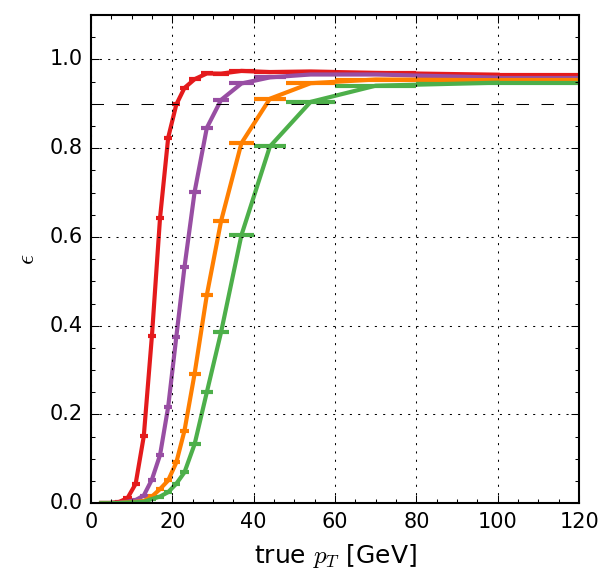

In [62]:
# Efficiency
eff_pt_bins = (0., 0.5, 1., 2., 3., 4., 5., 6., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

denom_hist, edges = np.histogram(eff_data[:, 1], bins=eff_pt_bins)

plt.figure()
pt_list = (10., 20., 30., 40., 50., 60.)

for pt, color in zip(pt_list, my_palette):
  passed = (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)
  eff_hist = np.true_divide(num_hist, denom_hist)
  print pt, eff_hist

  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = 0  #FIXME: get error bars
  ydata = eff_hist
  if pt == 10.:
    pass
  else:
    plt.errorbar(xdata, ydata, xerr=xerr, color=color, marker=',', capsize=0)

plt.plot(eff_pt_bins, np.ones_like(eff_pt_bins)*0.9, ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [63]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((4,nbinsx), dtype=np.float32)

for j in xrange(4):  # j = zone0-1, zone2-3, zone4-5, all zones
  if j == 3:
    eff_data_tmp = (eff_data[:,0] >= 0)
  else:
    eff_data_tmp = (eff_data[:,0] == 2*j) | (eff_data[:,0] == 2*j+1)
  xx = eff_data[:,1][eff_data_tmp]
  yy = eff_data[:,2][eff_data_tmp]
  zz = eff_data[:,4][eff_data_tmp]
  
  inds = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= inds) & (inds <= i+step)]
    yy_i = yy[(i <= inds) & (inds <= i+step)]
    zz_i = zz[(i <= inds) & (inds <= i+step)]
    coverage = 90  
    coverage += 2.5 # inefficiency due to fiducial cuts
    #coverage += 100. * (zz_i==0).sum() / (zz_i>=0).sum()  # inefficiency due to PU discr
    pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    # Debug
    if j == 3 and xedges[i] > discr_pt_cut:
      print i, xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    
    xxx[j,i] = pct

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

29 14.5 2.72727272727
30 15.0 2.65805961648
31 15.5 2.6412027631
32 16.0 2.54804577845
33 16.5 2.42465443009
34 17.0 2.25907233838
35 17.5 2.25525371604
36 18.0 2.2186581128
37 18.5 2.16413715571
38 19.0 2.34397890419
39 19.5 2.35834609495
40 20.0 2.45144858325
41 20.5 2.20957482424
42 21.0 2.36248236953
43 21.5 2.39270793771
44 22.0 2.44
45 22.5 2.3680930619
46 23.0 2.68980477223
47 23.5 2.53445975989
48 24.0 2.26432532348
49 24.5 1.93677015095
50 25.0 1.8711018711
51 25.5 1.70436938333
52 26.0 1.73913043478
53 26.5 1.82119205298
54 27.0 2.01709401709
55 27.5 2.03281027104
56 28.0 2.0641356432
57 28.5 1.82857142857
58 29.0 1.86770428016
59 29.5 1.90174326466
60 30.0 2.0782396088
61 30.5 2.05536912752
62 31.0 1.92884697814
63 31.5 1.81737588652
64 32.0 1.66358595194
65 32.5 1.56958493198
66 33.0 1.69125584743
67 33.5 1.81481481481
68 34.0 1.92975685064
69 34.5 1.79282868526
70 35.0 1.73553719008
71 35.5 1.66240409207
72 36.0 1.62494510321
73 36.5 1.77304964539
74 37.0 1.65198237885
75 

[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

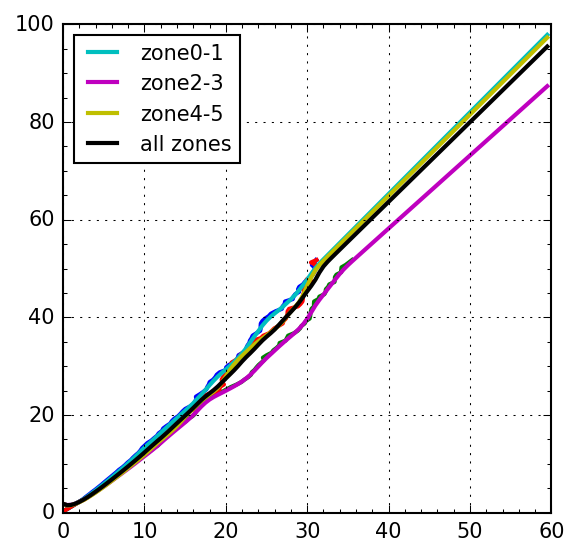

In [64]:
if True:
  plt.figure()
  xdata = (xedges[1:] + xedges[:-1])/2
  plt.plot(xxx[0,:-16], xdata[:-16])
  plt.plot(xxx[1,:-16], xdata[:-16])
  plt.plot(xxx[2,:-16], xdata[:-16])
  #plt.plot(xxx[3,:-16], xdata[:-16])

  from scipy.interpolate import Rbf
  rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
  rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

  xdata = xedges[:-1]
  ydata0 = rbf0(xdata)
  ydata1 = rbf1(xdata)
  ydata2 = rbf2(xdata)
  ydata3 = rbf3(xdata)
  
  line0, = plt.plot(xdata, ydata0)
  line1, = plt.plot(xdata, ydata1)
  line2, = plt.plot(xdata, ydata2)
  line3, = plt.plot(xdata, ydata3)
  
  print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
  #print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
  print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')
  
  plt.legend((line0, line1, line2, line3), ('zone0-1', 'zone2-3', 'zone4-5', 'all zones'), loc='upper left')
  plt.show()

In [65]:
# Rates
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for x, ndof, y_meas, y_discr, aux in zip(pu_x_test, pu_x_test_ndof, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test):
  zone = int(x[(nlayers*6) + 1] * 5)
  
  passed = mytrigger.pass_trigger(x, ndof, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid)
  ievt = int(ievt)
  
  if jobid < (rates_njobs-1):
    if passed:
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed:
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_job = 31
  if jobid == test_job and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(*aux), ndof, pt, y_discr

  31 2826 19.5646 30.0000 6 27.924449413000293 0.9970956
  31 2937 11.6057 19.5000 6 54.656621441580306 0.99979776
  31 3675  3.0667  8.5000 5 30.945508527122076 0.9744488
  31 3925  4.3738 10.5000 5 73.64736853572435 0.9942999
  31 4581  1.5532 24.0000 4 27.350605539979036 0.995269


[INFO    ] nevents: 258400/498400


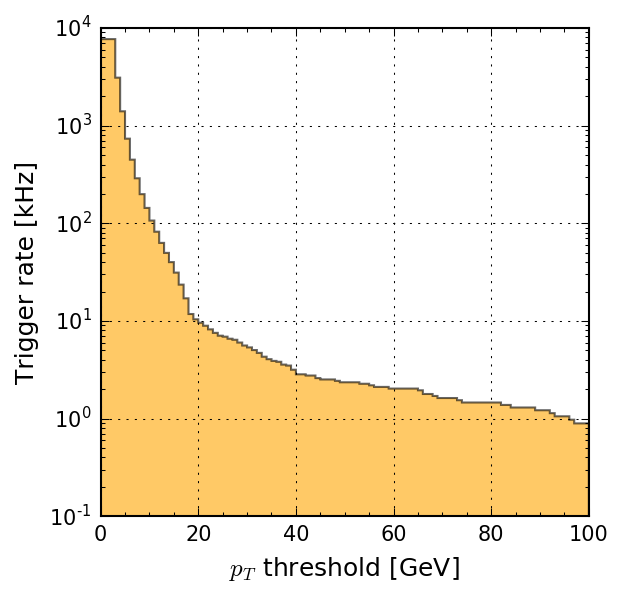

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 11.7752394974, 10.3946942389, 9.58260878921, 8.93294039369, 8.20206347108


[7.69467242e+03 7.69467242e+03 7.69467242e+03 3.10078618e+03
 1.40287774e+03 7.35830679e+02 4.48433615e+02 2.89102438e+02
 1.98798529e+02 1.43739131e+02 1.06708033e+02 8.20206342e+01
 6.30178342e+01 4.97808404e+01 4.00358148e+01 3.12652917e+01
 2.35504794e+01 1.70537954e+01 1.17752395e+01 1.03946942e+01
 9.58260879e+00 8.93294039e+00 8.20206347e+00 7.55239508e+00
 7.06514379e+00 6.90272669e+00 6.57789250e+00 6.41547540e+00
 6.00943264e+00 5.60338989e+00 5.35976425e+00 5.03493005e+00
 4.71009585e+00 4.30405310e+00 4.06042746e+00 3.89801036e+00
 3.81680181e+00 3.57317617e+00 3.49196762e+00 3.16713342e+00
 2.84229922e+00 2.84229922e+00 2.76109067e+00 2.76109067e+00
 2.59867357e+00 2.51746503e+00 2.51746503e+00 2.51746503e+00
 2.43625648e+00 2.35504793e+00 2.35504793e+00 2.35504793e+00
 2.35504793e+00 2.27383938e+00 2.27383938e+00 2.19263083e+00
 2.11142228e+00 2.11142228e+00 2.11142228e+00 2.03021373e+00
 2.03021373e+00 2.03021373e+00 2.03021373e+00 2.03021373e+00
 2.03021373e+00 1.949005

In [66]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11245.6
  nCollBunches = 1866
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
weights = np.zeros_like(rates) + conversion_to_kHz(rates_nevents_1)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', alpha=0.6)
#print hist, edges
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print hist

In [29]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [30]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    
    nentries_test = 100000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1) or lay in (11,):  # ME1/1, ME1/2, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (2,) or lay in (5,6) or lay in (9,10):  # ME2, RE1, RE2, GE1/1, GE2/1
          coef = 1.0/np.std(x_i)
        else:  # ME3, ME4, RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
    
      ## x_time
      #elif (nlayers*3) <= i < (nlayers*4):
      #  coef = 1.0/np.std(x_i)
      #  print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef  

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [31]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()